C:\Users\ThinkPad\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


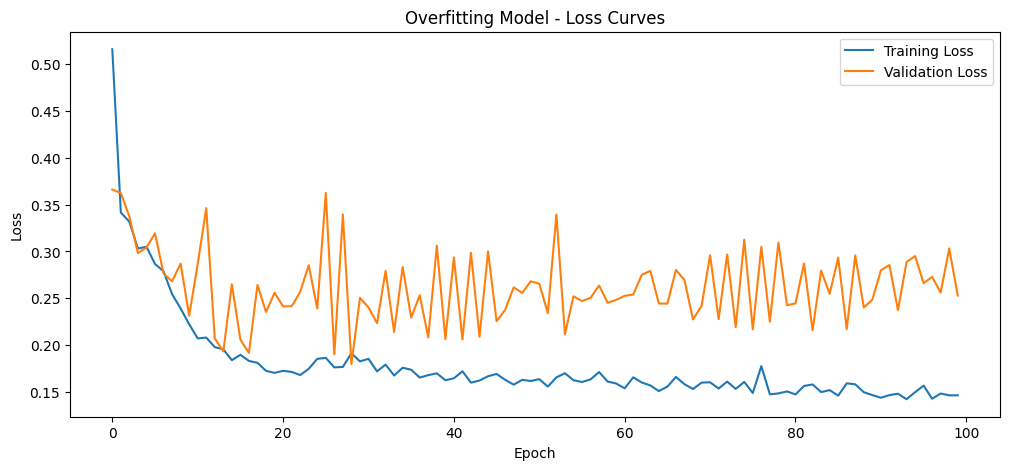

In [1]:
# Assignment 5.1: Overfitting Demonstration

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt

# 1. Generate synthetic data
X, y = make_moons(n_samples=500, noise=0.3, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. Build a model prone to overfitting (too complex for the data)
overfit_model = keras.Sequential([
    layers.Dense(512, activation='relu', input_shape=(2,)),
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

overfit_model.compile(optimizer='adam',
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

history_overfit = overfit_model.fit(X_train, y_train,
                                    epochs=100,
                                    batch_size=32,
                                    validation_data=(X_test, y_test),
                                    verbose=0) # verbose=0 for cleaner output

# 3. Plotting the results
plt.figure(figsize=(12, 5))
plt.plot(history_overfit.history['loss'], label='Training Loss')
plt.plot(history_overfit.history['val_loss'], label='Validation Loss')
plt.title('Overfitting Model - Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

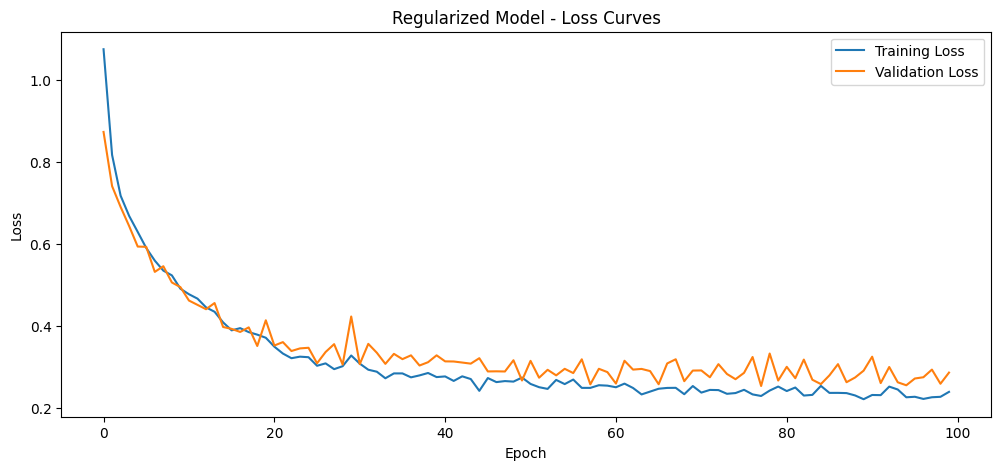

In [2]:
# Assignment 5.1: Preventing Overfitting

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt

# 1. Use the same data as before
X, y = make_moons(n_samples=500, noise=0.3, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. Build a regularized model
regularized_model = keras.Sequential([
    layers.Dense(512, activation='relu', 
                 kernel_regularizer=regularizers.l2(0.001), # L2 Regularization
                 input_shape=(2,)),
    layers.Dropout(0.5), # Dropout Layer
    layers.Dense(256, activation='relu',
                 kernel_regularizer=regularizers.l2(0.001)), # L2 Regularization
    layers.Dropout(0.5), # Dropout Layer
    layers.Dense(128, activation='relu',
                 kernel_regularizer=regularizers.l2(0.001)), # L2 Regularization
    layers.Dropout(0.5), # Dropout Layer
    layers.Dense(1, activation='sigmoid')
])

regularized_model.compile(optimizer='adam',
                          loss='binary_crossentropy',
                          metrics=['accuracy'])

history_regularized = regularized_model.fit(X_train, y_train,
                                            epochs=100,
                                            batch_size=32,
                                            validation_data=(X_test, y_test),
                                            verbose=0)

# 3. Plotting the results
plt.figure(figsize=(12, 5))
plt.plot(history_regularized.history['loss'], label='Training Loss')
plt.plot(history_regularized.history['val_loss'], label='Validation Loss')
plt.title('Regularized Model - Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [3]:
# Assignment 5.2: Setup from Assignment 4.2

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt

# 1. Load and Prepare the Data
FILE_PATH = r"..\data42.csv"
df = pd.read_csv(FILE_PATH)

# Feature Engineering: Create BMI and BMI_Category
df['bmi'] = df['weight_kg'] / ((df['height_cm'] / 100) ** 2)
def categorize_bmi(bmi):
    if bmi < 18.5: return 'Underweight'
    elif 18.5 <= bmi < 25: return 'Normal'
    else: return 'Overweight'
df['BMI_Category'] = df['bmi'].apply(categorize_bmi)

# 2. Preprocessing for Neural Networks
features_to_drop = ['id', 'name', 'height_cm', 'weight_kg', 'bmi', 'BMI_Category']
X = df.drop(columns=features_to_drop)
y = df['BMI_Category']
y_encoded = pd.get_dummies(y).values

# Identify numerical and categorical features for preprocessing
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Create the preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Split and process data
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)
X_train_processed = preprocessor.fit_transform(X_train).toarray()
X_test_processed = preprocessor.transform(X_test).toarray()

# Get the number of features after one-hot encoding
n_features = X_train_processed.shape[1]
n_classes = y_train.shape[1]

# Reshape Data for CNN
X_train_cnn = X_train_processed.reshape((X_train_processed.shape[0], n_features, 1))
X_test_cnn = X_test_processed.reshape((X_test_processed.shape[0], n_features, 1))

print(f"n_features={n_features}")

n_features=663


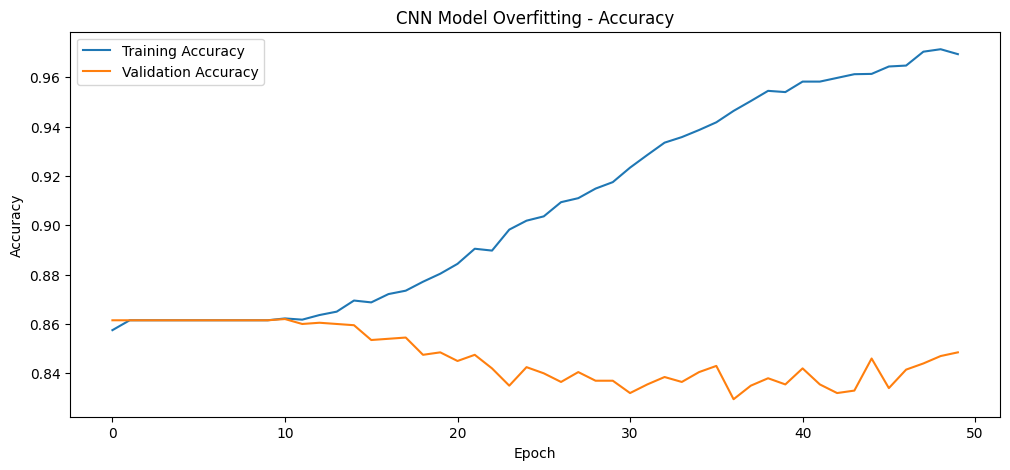

In [4]:
# Assignment 5.2: Inducing Overfitting

# Define the CNN model structure from Assignment 4.2
def build_cnn_model(input_shape):
    model = keras.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv1D(filters=32, kernel_size=3, activation='relu'),
        layers.MaxPooling1D(pool_size=2),
        layers.Conv1D(filters=64, kernel_size=3, activation='relu'),
        layers.Flatten(),
        layers.Dense(100, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(n_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Train for more epochs to induce overfitting
cnn_overfit = build_cnn_model((n_features, 1))
history_cnn_overfit = cnn_overfit.fit(X_train_cnn, y_train,
                                      epochs=50,
                                      batch_size=64,
                                      validation_data=(X_test_cnn, y_test),
                                      verbose=0)

# Plot the accuracy
plt.figure(figsize=(12, 5))
plt.plot(history_cnn_overfit.history['accuracy'], label='Training Accuracy')
plt.plot(history_cnn_overfit.history['val_accuracy'], label='Validation Accuracy')
plt.title('CNN Model Overfitting - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

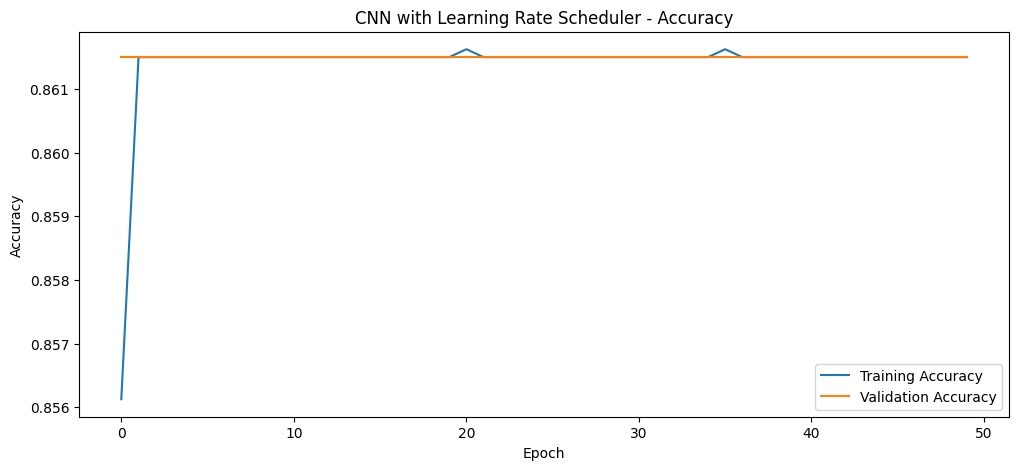

In [5]:
# Assignment 5.2: Applying Learning Rate Scheduler

from tensorflow.keras.callbacks import ReduceLROnPlateau

# Define the learning rate scheduler callback
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', # metric to watch
                                 factor=0.2,       # factor to reduce LR by
                                 patience=3,       # epochs to wait for improvement
                                 min_lr=0.00001)   # minimum learning rate

cnn_lr_tuned = build_cnn_model((n_features, 1))

history_cnn_lr = cnn_lr_tuned.fit(X_train_cnn, y_train,
                                  epochs=50,
                                  batch_size=64,
                                  validation_data=(X_test_cnn, y_test),
                                  callbacks=[lr_scheduler], # Add the callback here
                                  verbose=0)

# Plot the accuracy
plt.figure(figsize=(12, 5))
plt.plot(history_cnn_lr.history['accuracy'], label='Training Accuracy')
plt.plot(history_cnn_lr.history['val_accuracy'], label='Validation Accuracy')
plt.title('CNN with Learning Rate Scheduler - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

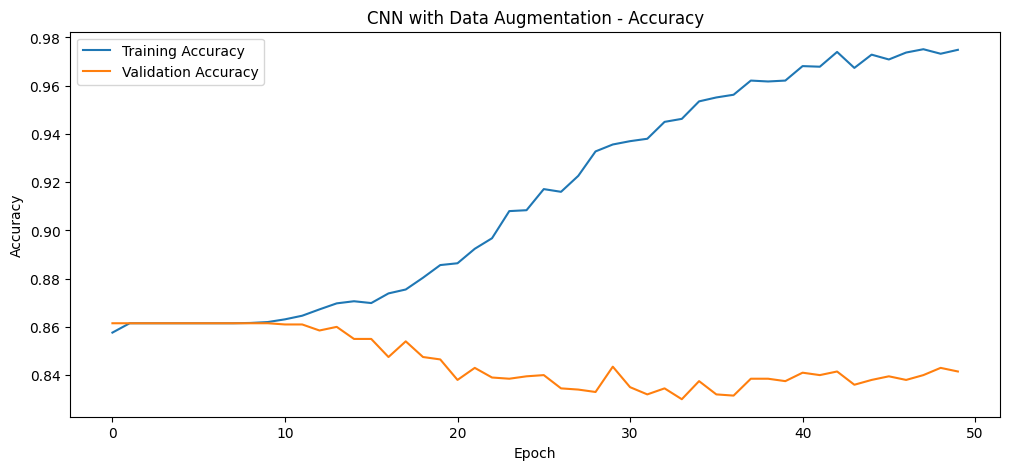

In [6]:
# Assignment 5.2: Applying Data Augmentation

# Create a function to add noise
def augment_data(X_data, noise_level=0.2):
    # Find the columns that are numerical (before one-hot encoding)
    num_feature_indices = [X.columns.get_loc(c) for c in numerical_features]
    
    X_augmented = X_data.copy()
    # Generate noise with the same shape as the numerical part
    noise = np.random.normal(0, noise_level, size=(X_data.shape[0], len(num_feature_indices)))
    
    # We need to know which columns in the PROCESSED data correspond to numerical features.
    # Since StandardScaler was used, they are the first columns.
    num_cols_processed = len(num_feature_indices)
    X_augmented[:, :num_cols_processed] += noise
    return X_augmented

# Augment the training data
X_train_augmented = augment_data(X_train_processed)
X_train_cnn_aug = X_train_augmented.reshape((X_train_augmented.shape[0], n_features, 1))

# Build and train a new model on the augmented data
cnn_augmented = build_cnn_model((n_features, 1))

history_cnn_aug = cnn_augmented.fit(X_train_cnn_aug, y_train,
                                    epochs=50,
                                    batch_size=64,
                                    validation_data=(X_test_cnn, y_test),
                                    verbose=0)

# Plot the accuracy
plt.figure(figsize=(12, 5))
plt.plot(history_cnn_aug.history['accuracy'], label='Training Accuracy')
plt.plot(history_cnn_aug.history['val_accuracy'], label='Validation Accuracy')
plt.title('CNN with Data Augmentation - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [19]:
# Assignment 5.4.a: Load Dataset

import pandas as pd

# Define the file path
# Please make sure this file is available on your computer
FILE_PATH_REVIEW = r"..\filmReview_1.csv" 

try:
    df_reviews = pd.read_csv(FILE_PATH_REVIEW)
    print("--- Dataset 'filmReview_1.csv' loaded ---")
    print("\nDataset Info:")
    df_reviews.info()
    
    print("\nFirst 5 rows of the dataset:")
    print(df_reviews.head())
    
except FileNotFoundError:
    print(f"ERROR: The file was not found at {FILE_PATH_REVIEW}")
    print("Please download the 'filmReview_1.csv' file and place it in the C:\\DATA directory.")
    # Create a dummy dataframe to allow the rest of the code to run for demonstration
    data = {
        'review_id': range(5),
        'user_id': ['user_001']*5,
        'user_name': ['user1']*5,
        'film_title': ['Movie A', 'Movie B', 'Movie C', 'Movie D', 'Movie E'],
        'rating': [8, 2, 9, 4, 7],
        'review_text': [
            'This movie was absolutely fantastic! The acting was superb.',
            'A complete waste of time. The plot was predictable and boring.',
            'A masterpiece of cinema. I was captivated from start to finish.',
            'It was an okay movie, nothing special but not terrible either.',
            'I enjoyed it a lot. The characters were very well developed.'
        ],
        'review_date': ['2023-01-01']*5
    }
    df_reviews = pd.DataFrame(data)
    print("\n--- Created a dummy dataframe for demonstration purposes. ---")

--- Dataset 'filmReview_1.csv' loaded ---

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   review_id    5000 non-null   int64 
 1   user_id      5000 non-null   int64 
 2   user_name    5000 non-null   object
 3   film_title   5000 non-null   object
 4   rating       5000 non-null   int64 
 5   review_text  5000 non-null   object
 6   review_date  5000 non-null   object
dtypes: int64(3), object(4)
memory usage: 273.6+ KB

First 5 rows of the dataset:
   review_id  user_id user_name        film_title  rating  \
0          1      328  user_328         Inception       1   
1          2       72  user_072  Double Indemnity       4   
2          3      217  user_217           Vertigo       1   
3          4      309  user_309  Schindler's List       8   
4          5      230  user_230    Shutter Island       6   

                   

In [20]:
# Assignment 5.4.b: Word Vector Representation using spaCy

# You need to install spaCy and its model first:
# 1. pip install spacy
# 2. python -m spacy download en_core_web_sm

import spacy
import numpy as np

# Load the pre-trained spaCy model
try:
    nlp = spacy.load("en_core_web_sm")
    print("--- spaCy model 'en_core_web_sm' loaded ---")
    
    # spaCy's .vector attribute gives an average vector for the whole text
    # This is much more convenient than averaging word vectors manually.
    
    # Demonstrate on a sample review
    sample_review = df_reviews['review_text'].iloc[0]
    
    # Process the text with the spaCy pipeline
    doc = nlp(sample_review)
    
    # Get the sentence vector
    sample_vector_spacy = doc.vector
    
    print(f"\nSample Review: '{sample_review}'")
    print(f"Shape of spaCy vector: {sample_vector_spacy.shape}")
    print(f"First 10 dimensions of the vector:\n{sample_vector_spacy[:10]}")

except OSError:
    print("\nERROR: spaCy model 'en_core_web_sm' not found.")
    print("Please run this command in your terminal or command prompt:")
    print("python -m spacy download en_core_web_sm")

--- spaCy model 'en_core_web_sm' loaded ---

Sample Review: 'Not my cup of tea. I struggled to finish it. Really well done.'
Shape of spaCy vector: (96,)
First 10 dimensions of the vector:
[-0.14786586 -0.34936723 -0.23698813 -0.03974703 -0.12424128  0.03811279
  0.4627908   0.02591087 -0.19495548  0.16215189]


In [9]:
# Assignment 5.4.c&d: Keras Data Preparation

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import MinMaxScaler

# Define features (X) and target (y)
X = df_reviews['review_text']
y = df_reviews['rating'].values

# Normalize the target 'rating' to be between 0 and 1
scaler = MinMaxScaler()
y_scaled = scaler.fit_transform(y.reshape(-1, 1))

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y_scaled, test_size=0.2, random_state=42)

# Tokenize the text data
vocab_size = 10000  # Consider only the top 10,000 words
oov_token = "<OOV>" # Token for out-of-vocabulary words
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(X_train)

# Convert texts to sequences of integers
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad the sequences to ensure uniform length
max_length = 100 # Max length of a review
padding_type = 'post'
truncation_type = 'post'
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding=padding_type, truncating=truncation_type)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding=padding_type, truncating=truncation_type)

print(f"Shape of padded training data: {X_train_pad.shape}")
print(f"Shape of training labels: {y_train.shape}")

Shape of padded training data: (4, 100)
Shape of training labels: (4, 1)


C:\Users\ThinkPad\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)


--- Training Overfitting LSTM Model ---
Epoch 1/20
1/1 - 3s - 3s/step - loss: 0.1182 - mae: 0.3222 - val_loss: 0.2554 - val_mae: 0.5054
Epoch 2/20
1/1 - 0s - 89ms/step - loss: 0.1153 - mae: 0.3189 - val_loss: 0.2597 - val_mae: 0.5096
Epoch 3/20
1/1 - 0s - 94ms/step - loss: 0.1133 - mae: 0.3164 - val_loss: 0.2650 - val_mae: 0.5148
Epoch 4/20
1/1 - 0s - 93ms/step - loss: 0.1109 - mae: 0.3133 - val_loss: 0.2722 - val_mae: 0.5218
Epoch 5/20
1/1 - 0s - 91ms/step - loss: 0.1080 - mae: 0.3096 - val_loss: 0.2810 - val_mae: 0.5301
Epoch 6/20
1/1 - 0s - 95ms/step - loss: 0.1047 - mae: 0.3050 - val_loss: 0.2917 - val_mae: 0.5401
Epoch 7/20
1/1 - 0s - 92ms/step - loss: 0.1008 - mae: 0.2996 - val_loss: 0.3051 - val_mae: 0.5523
Epoch 8/20
1/1 - 0s - 94ms/step - loss: 0.0964 - mae: 0.2930 - val_loss: 0.3219 - val_mae: 0.5673
Epoch 9/20
1/1 - 0s - 98ms/step - loss: 0.0913 - mae: 0.2849 - val_loss: 0.3434 - val_mae: 0.5860
Epoch 10/20
1/1 - 0s - 96ms/step - loss: 0.0857 - mae: 0.2748 - val_loss: 0.372

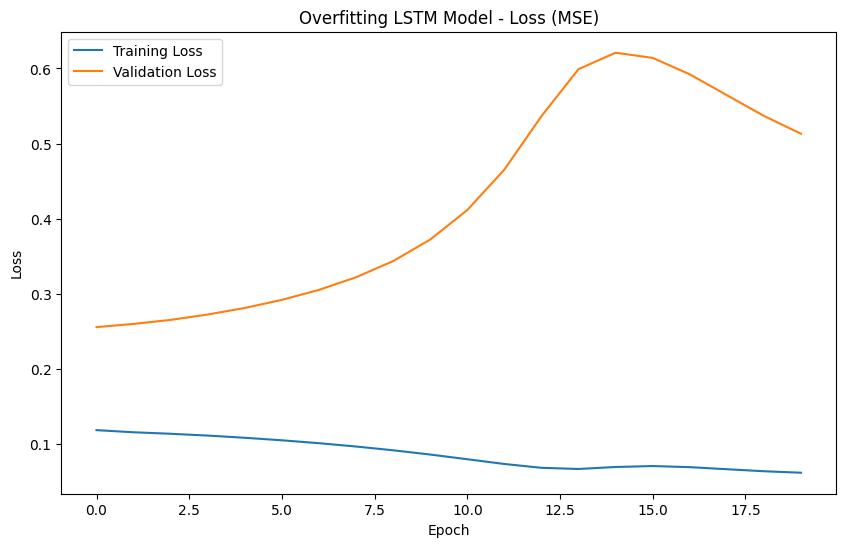

In [10]:
# Assignment 5.4.c&d: LSTM Model with Overfitting

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
import matplotlib.pyplot as plt

# Model parameters
embedding_dim = 64

# Build the model
overfit_lstm = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    Bidirectional(LSTM(64)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid') # Sigmoid for output between 0 and 1
])

# Compile the model for regression
overfit_lstm.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])
overfit_lstm.summary()

print("\n--- Training Overfitting LSTM Model ---")
history_overfit = overfit_lstm.fit(X_train_pad, y_train,
                                   epochs=20,
                                   validation_data=(X_test_pad, y_test),
                                   verbose=2)

# Plotting the loss
plt.figure(figsize=(10, 6))
plt.plot(history_overfit.history['loss'], label='Training Loss')
plt.plot(history_overfit.history['val_loss'], label='Validation Loss')
plt.title('Overfitting LSTM Model - Loss (MSE)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

--- Training Improved LSTM Model with Dropout and Early Stopping ---
Epoch 1/20
1/1 - 5s - 5s/step - loss: 0.1178 - mae: 0.3217 - val_loss: 0.2511 - val_mae: 0.5011
Epoch 2/20
1/1 - 0s - 125ms/step - loss: 0.1150 - mae: 0.3180 - val_loss: 0.2559 - val_mae: 0.5059
Epoch 3/20
1/1 - 0s - 119ms/step - loss: 0.1156 - mae: 0.3200 - val_loss: 0.2640 - val_mae: 0.5138
Epoch 4/20
1/1 - 0s - 118ms/step - loss: 0.1181 - mae: 0.3250 - val_loss: 0.2718 - val_mae: 0.5214


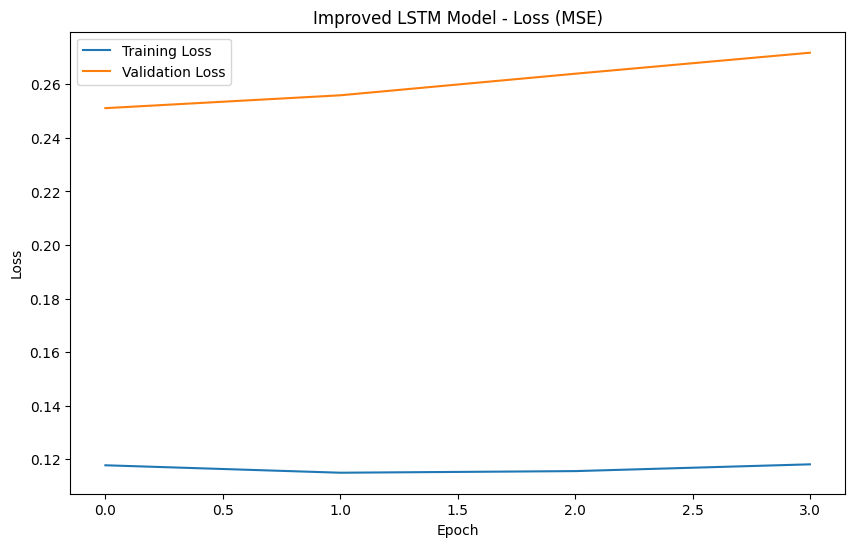

In [11]:
# Assignment 5.4.d: Improved LSTM Model

from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Define the improved model with Dropout
improved_lstm = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    Bidirectional(LSTM(64, return_sequences=True)), # Return sequences for next LSTM layer
    Dropout(0.4), # Add dropout
    Bidirectional(LSTM(32)),
    Dropout(0.4), # Add dropout
    Dense(32, activation='relu'),
    Dropout(0.4), # Add dropout
    Dense(1, activation='sigmoid')
])

# Compile the model
improved_lstm.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])

# Define Early Stopping
# This will stop training when the validation loss has not improved for 3 epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

print("--- Training Improved LSTM Model with Dropout and Early Stopping ---")
history_improved = improved_lstm.fit(X_train_pad, y_train,
                                     epochs=20, # We can set a high number, early stopping will handle it
                                     validation_data=(X_test_pad, y_test),
                                     callbacks=[early_stopping],
                                     verbose=2)

# Plotting the loss
plt.figure(figsize=(10, 6))
plt.plot(history_improved.history['loss'], label='Training Loss')
plt.plot(history_improved.history['val_loss'], label='Validation Loss')
plt.title('Improved LSTM Model - Loss (MSE)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [13]:
# Cell 1: Import libraries và generate/load data từ Assignment 4.2 (FIXED)
import pandas as pd
import numpy as np
from faker import Faker
import os
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, SimpleRNN, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

# Generate dataset from Assignment 4.2 (tái tạo dựa trên truncated code)
fake = Faker()
NUM_PERSONS = 10000
FILE_PATH = "data_4.2.csv"  # Save locally

# Define features (numerical + categorical)
numerical_features = ['age', 'height_cm', 'weight_kg', 'daily_steps', 'hours_of_sleep', 
                      'water_intake_liters', 'alcohol_consumption_per_week', 'fast_food_frequency_per_week', 
                      'stress_level', 'heart_rate_bpm', 'blood_pressure_systolic', 'cholesterol_total']
categorical_features = ['gender', 'job', 'area', 'diet_type', 'smoker', 'family_history_overweight']

# Generate fake data (simplified version)
data = {
    'id': range(1, NUM_PERSONS + 1),
    'name': [fake.name() for _ in range(NUM_PERSONS)],
    'age': np.random.randint(18, 80, NUM_PERSONS),
    'gender': np.random.choice(['Male', 'Female'], NUM_PERSONS),
    'job': [fake.job() for _ in range(NUM_PERSONS)],
    'area': np.random.choice(['Urban', 'Suburban', 'Rural'], NUM_PERSONS),
    'height_cm': np.random.normal(170, 10, NUM_PERSONS).clip(150, 200),
    'weight_kg': np.random.normal(70, 15, NUM_PERSONS).clip(40, 120),
    'diet_type': np.random.choice(['Balanced', 'Vegan', 'Low-carb', 'Keto', 'Mediterranean'], NUM_PERSONS),
    'daily_steps': np.random.randint(2000, 15000, NUM_PERSONS),
    'hours_of_sleep': np.random.uniform(4, 10, NUM_PERSONS),
    'water_intake_liters': np.random.uniform(1, 4, NUM_PERSONS),
    'smoker': np.random.choice(['Yes', 'No'], NUM_PERSONS),
    'alcohol_consumption_per_week': np.random.randint(0, 20, NUM_PERSONS),
    'fast_food_frequency_per_week': np.random.randint(0, 10, NUM_PERSONS),
    'stress_level': np.random.randint(1, 10, NUM_PERSONS),
    'heart_rate_bpm': np.random.normal(70, 10, NUM_PERSONS).clip(50, 100),
    'blood_pressure_systolic': np.random.normal(120, 15, NUM_PERSONS).clip(90, 160),
    'cholesterol_total': np.random.normal(200, 40, NUM_PERSONS).clip(120, 300),
    'family_history_overweight': np.random.choice(['Yes', 'No'], NUM_PERSONS)
}

# Calculate BMI as target (for regression, but we'll use category for classification)
df = pd.DataFrame(data)
df['bmi'] = df['weight_kg'] / ((df['height_cm'] / 100) ** 2)
df['bmi_category'] = pd.cut(df['bmi'], bins=[0, 18.5, 25, 30, np.inf], labels=['Underweight', 'Normal', 'Overweight', 'Obese'])

# Save
df.to_csv(FILE_PATH, index=False)
print(f"Dataset generated and saved to {FILE_PATH}")
print(df.head())

# Preprocess: Split train/val/test (70/15/15), scale numerical, one-hot categorical
X = df.drop(['id', 'name', 'bmi', 'bmi_category'], axis=1)
y = df['bmi_category']

# Label encode y for classification
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_cat = to_categorical(y_encoded, num_classes=4)  # 4 classes

# Split: train/val/test
X_temp, X_test, y_temp_cat, y_test_cat = train_test_split(X, y_cat, test_size=0.15, random_state=42)
X_train, X_val, y_train_cat, y_val_cat = train_test_split(X_temp, y_temp_cat, test_size=0.1765, random_state=42)  # 15% val from 85%

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# FIX: Fit and transform, then .toarray() to convert sparse to dense
X_train_processed = preprocessor.fit_transform(X_train).toarray()  # <-- Thêm .toarray()
X_val_processed = preprocessor.transform(X_val).toarray()         # <-- Thêm .toarray()
X_test_processed = preprocessor.transform(X_test).toarray()       # <-- Thêm .toarray()

# Reshape for RNN/LSTM: (samples, timesteps=1, features) - Bây giờ an toàn vì dense
n_features = X_train_processed.shape[1]
X_train_rnn = X_train_processed.reshape((X_train_processed.shape[0], 1, n_features))
X_val_rnn = X_val_processed.reshape((X_val_processed.shape[0], 1, n_features))
X_test_rnn = X_test_processed.reshape((X_test_processed.shape[0], 1, n_features))

print(f"Processed shapes: X_train {X_train_rnn.shape}, y_train {y_train_cat.shape}")

Dataset generated and saved to data_4.2.csv
   id            name  age  gender                 job      area   height_cm  \
0   1  Derrick Tucker   56  Female  Editor, film/video     Rural  182.761042   
1   2     Sarah Kelly   69  Female    Industrial buyer     Urban  170.687034   
2   3     Mark Carter   46    Male   Financial planner     Rural  171.158341   
3   4  Regina Pearson   32    Male           Press sub  Suburban  186.242122   
4   5       Brian Lee   60    Male   Fisheries officer     Rural  159.034359   

   weight_kg diet_type  daily_steps  ...  smoker  \
0  77.966193      Keto         3546  ...      No   
1  79.555880  Low-carb         3611  ...     Yes   
2  80.871067  Low-carb         5977  ...     Yes   
3  74.458826  Balanced         7107  ...     Yes   
4  80.843346      Keto         6149  ...     Yes   

   alcohol_consumption_per_week fast_food_frequency_per_week  stress_level  \
0                             6                            8             2   
1     

In [14]:
# Cell 2: Data Augmentation function (tương tự CNN, noise_level=0.1 cho numerical)
def augment_data(X_data, noise_level=0.1):
    # Numerical indices (first len(numerical_features) columns after preprocessing)
    num_cols = len(numerical_features)
    X_aug = X_data.copy()
    noise = np.random.normal(0, noise_level, size=(X_data.shape[0], num_cols, 1))  # Shape for RNN (samples, 1, num_cols)
    X_aug[:, 0, :num_cols] += noise.squeeze()  # Add to first timestep, numerical cols
    return X_aug

# Augment train
X_train_aug_rnn = augment_data(X_train_rnn)
print("Augmentation applied.")

Augmentation applied.


C:\Users\ThinkPad\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


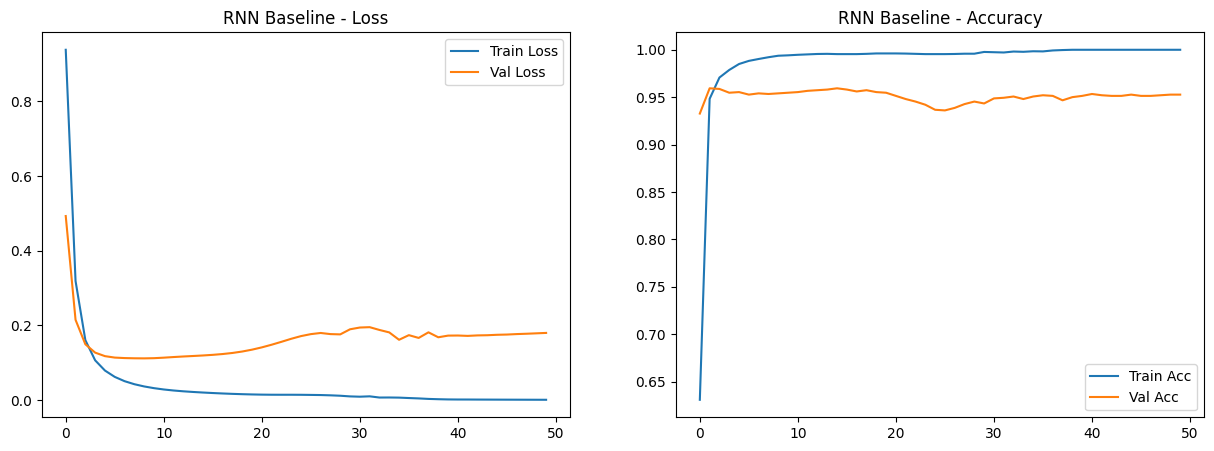

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9440 - loss: 0.2287
RNN Baseline Test Acc: 0.9440


In [15]:
# Cell 3: Build and train RNN Baseline (Overfitting)
def build_rnn_baseline(input_shape, n_classes=4):
    model = Sequential([
        SimpleRNN(64, input_shape=input_shape, return_sequences=False),
        Dense(32, activation='relu'),
        Dense(n_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Train baseline RNN
rnn_baseline = build_rnn_baseline((1, n_features))
history_rnn_baseline = rnn_baseline.fit(X_train_rnn, y_train_cat,
                                        epochs=50,
                                        batch_size=64,
                                        validation_data=(X_val_rnn, y_val_cat),  # Use val, not test
                                        verbose=0)

# Plot baseline
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(history_rnn_baseline.history['loss'], label='Train Loss')
ax1.plot(history_rnn_baseline.history['val_loss'], label='Val Loss')
ax1.set_title('RNN Baseline - Loss')
ax1.legend()

ax2.plot(history_rnn_baseline.history['accuracy'], label='Train Acc')
ax2.plot(history_rnn_baseline.history['val_accuracy'], label='Val Acc')
ax2.set_title('RNN Baseline - Accuracy')
ax2.legend()
plt.show()

# Evaluate on test
test_loss, test_acc = rnn_baseline.evaluate(X_test_rnn, y_test_cat)
print(f"RNN Baseline Test Acc: {test_acc:.4f}")

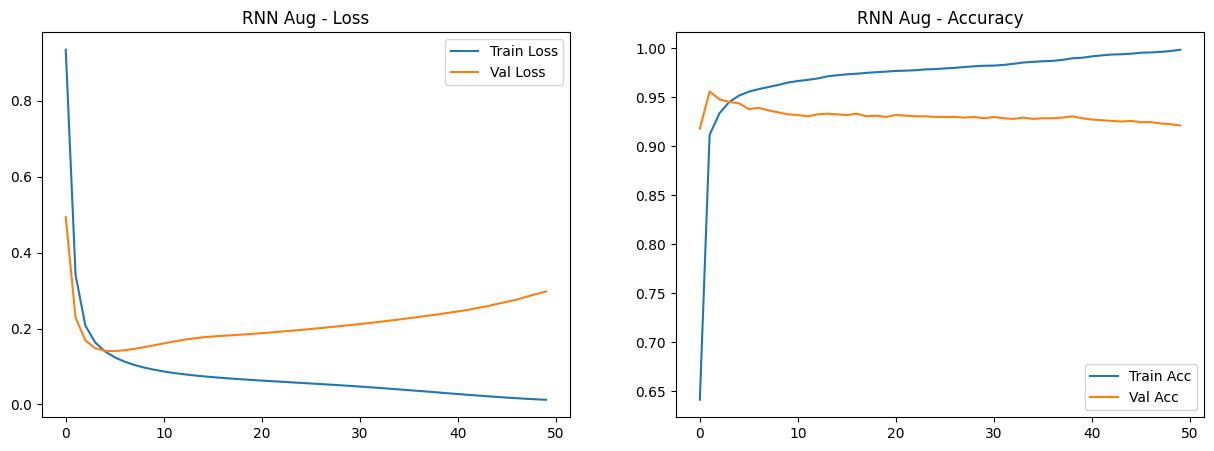

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9147 - loss: 0.3302
RNN Aug Test Acc: 0.9147


In [16]:
# Cell 4: RNN with Data Augmentation
rnn_aug = build_rnn_baseline((1, n_features))
history_rnn_aug = rnn_aug.fit(X_train_aug_rnn, y_train_cat,  # Use augmented
                              epochs=50,
                              batch_size=64,
                              validation_data=(X_val_rnn, y_val_cat),
                              verbose=0)

# Plot aug
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(history_rnn_aug.history['loss'], label='Train Loss')
ax1.plot(history_rnn_aug.history['val_loss'], label='Val Loss')
ax1.set_title('RNN Aug - Loss')
ax1.legend()

ax2.plot(history_rnn_aug.history['accuracy'], label='Train Acc')
ax2.plot(history_rnn_aug.history['val_accuracy'], label='Val Acc')
ax2.set_title('RNN Aug - Accuracy')
ax2.legend()
plt.show()

test_loss_aug, test_acc_aug = rnn_aug.evaluate(X_test_rnn, y_test_cat)
print(f"RNN Aug Test Acc: {test_acc_aug:.4f}")

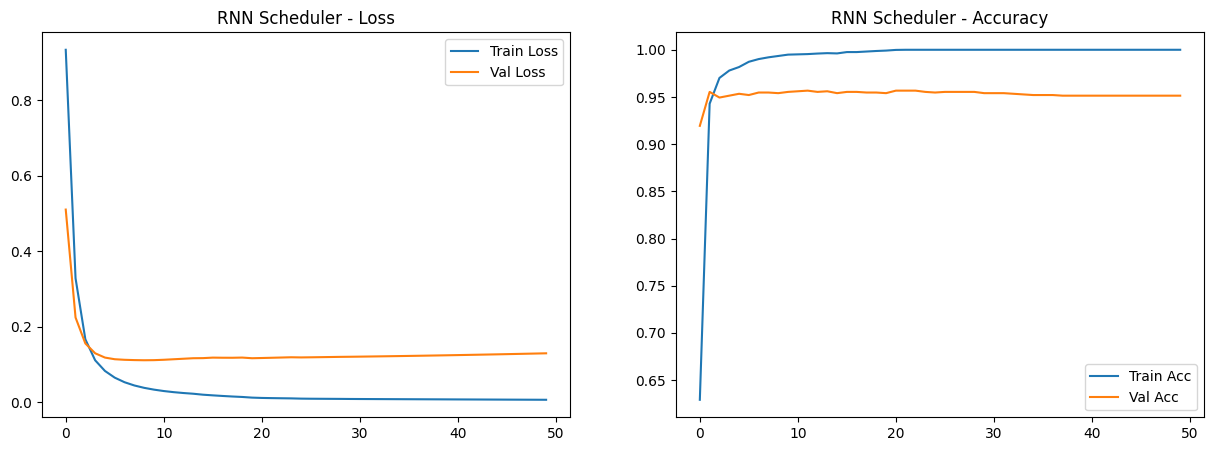

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9460 - loss: 0.1554 
RNN Scheduler Test Acc: 0.9460


In [17]:
# Cell 5: RNN with LR Scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.0001)

rnn_scheduler = build_rnn_baseline((1, n_features))
history_rnn_scheduler = rnn_scheduler.fit(X_train_rnn, y_train_cat,
                                          epochs=50,
                                          batch_size=64,
                                          validation_data=(X_val_rnn, y_val_cat),
                                          callbacks=[lr_scheduler],
                                          verbose=0)

# Plot scheduler
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(history_rnn_scheduler.history['loss'], label='Train Loss')
ax1.plot(history_rnn_scheduler.history['val_loss'], label='Val Loss')
ax1.set_title('RNN Scheduler - Loss')
ax1.legend()

ax2.plot(history_rnn_scheduler.history['accuracy'], label='Train Acc')
ax2.plot(history_rnn_scheduler.history['val_accuracy'], label='Val Acc')
ax2.set_title('RNN Scheduler - Accuracy')
ax2.legend()
plt.show()

test_loss_sch, test_acc_sch = rnn_scheduler.evaluate(X_test_rnn, y_test_cat)
print(f"RNN Scheduler Test Acc: {test_acc_sch:.4f}")

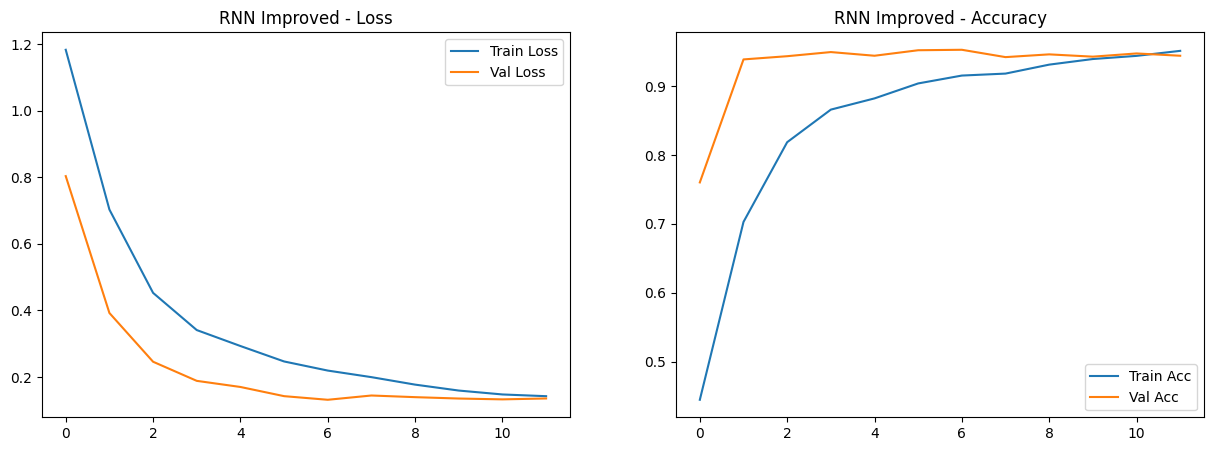

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9427 - loss: 0.1402
RNN Improved Test Acc: 0.9427


In [18]:
# Cell 6: RNN Improved (Dropout + EarlyStopping)
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

def build_rnn_improved(input_shape, n_classes=4):
    model = Sequential([
        SimpleRNN(64, input_shape=input_shape, return_sequences=False),
        Dropout(0.4),
        Dense(32, activation='relu'),
        Dropout(0.4),
        Dense(n_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

rnn_improved = build_rnn_improved((1, n_features))
history_rnn_improved = rnn_improved.fit(X_train_rnn, y_train_cat,
                                        epochs=50,
                                        batch_size=64,
                                        validation_data=(X_val_rnn, y_val_cat),
                                        callbacks=[early_stop],
                                        verbose=0)

# Plot improved
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(history_rnn_improved.history['loss'], label='Train Loss')
ax1.plot(history_rnn_improved.history['val_loss'], label='Val Loss')
ax1.set_title('RNN Improved - Loss')
ax1.legend()

ax2.plot(history_rnn_improved.history['accuracy'], label='Train Acc')
ax2.plot(history_rnn_improved.history['val_accuracy'], label='Val Acc')
ax2.set_title('RNN Improved - Accuracy')
ax2.legend()
plt.show()

test_loss_imp, test_acc_imp = rnn_improved.evaluate(X_test_rnn, y_test_cat)
print(f"RNN Improved Test Acc: {test_acc_imp:.4f}")

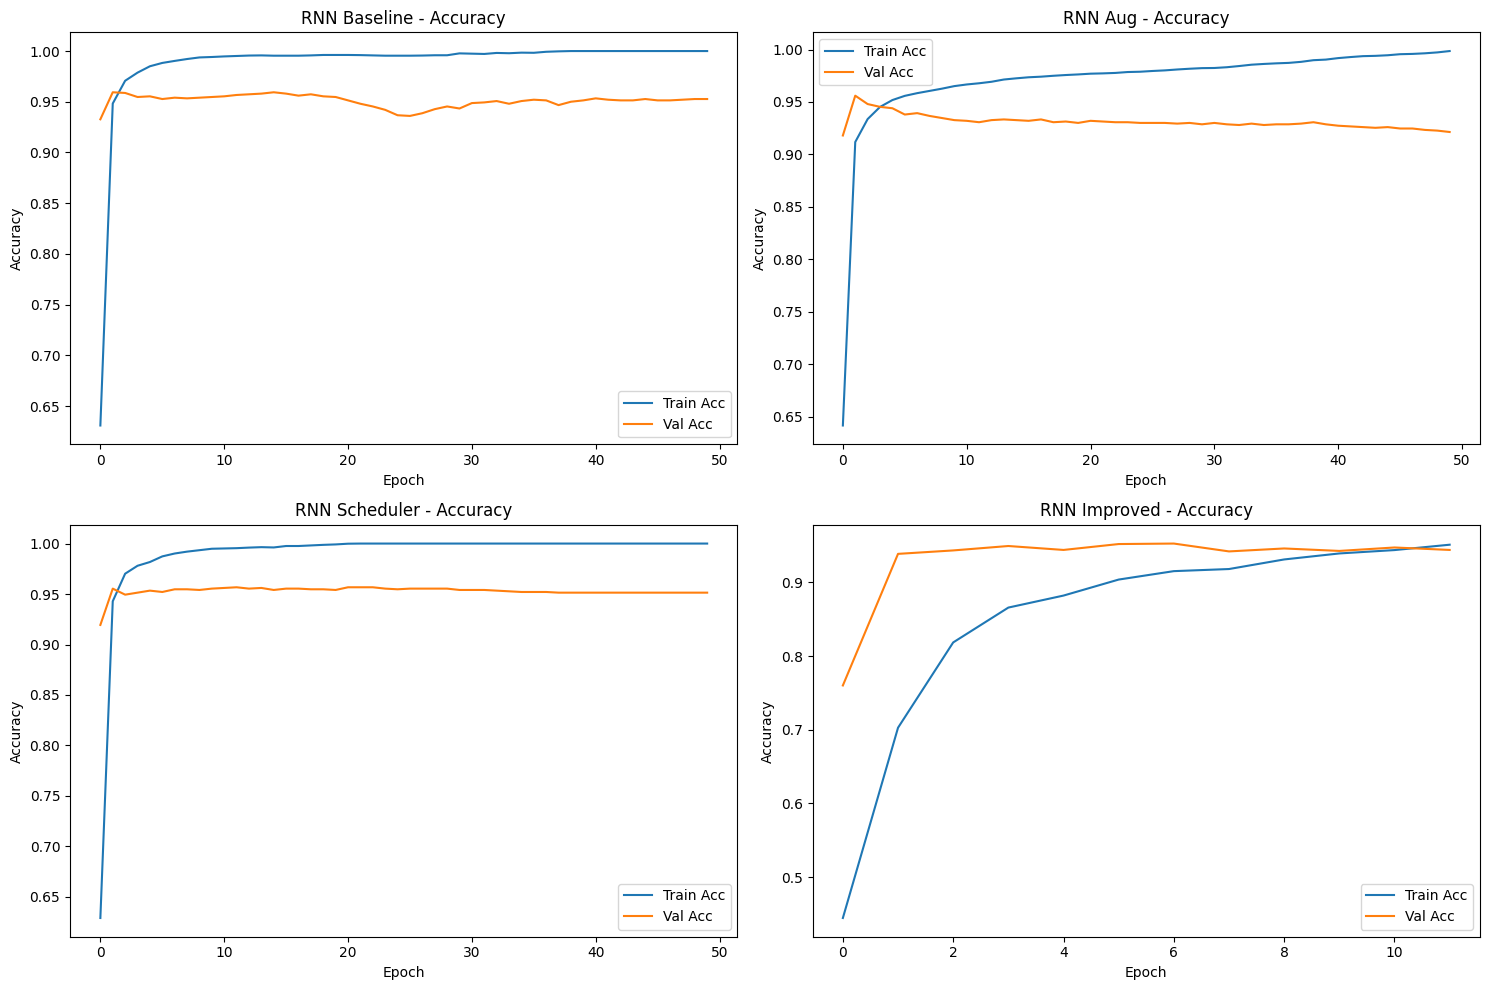

RNN Comparison:
Method       Test Acc   Gap (Train-Val)
Baseline     0.9527     0.0473
Aug          0.9214     0.0772
Scheduler    0.9514     0.0486
Improved     0.9440     0.0071


In [19]:
# Cell 7: So sánh RNN methods (subplots như Assignment 5)
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
methods = ['Baseline', 'Aug', 'Scheduler', 'Improved']
histories = [history_rnn_baseline, history_rnn_aug, history_rnn_scheduler, history_rnn_improved]

for i, (method, history) in enumerate(zip(methods, histories)):
    row, col = i // 2, i % 2
    axes[row, col].plot(history.history['accuracy'], label='Train Acc')
    axes[row, col].plot(history.history['val_accuracy'], label='Val Acc')
    axes[row, col].set_title(f'RNN {method} - Accuracy')
    axes[row, col].legend()
    axes[row, col].set_xlabel('Epoch')
    axes[row, col].set_ylabel('Accuracy')

plt.tight_layout()
plt.show()

# Summary table
print("RNN Comparison:")
print(f"{'Method':<12} {'Test Acc':<10} {'Gap (Train-Val)':<15}")
for method, history in zip(methods, histories):
    final_train = history.history['accuracy'][-1]
    final_val = history.history['val_accuracy'][-1]
    gap = final_train - final_val
    print(f"{method:<12} {final_val:.4f}     {gap:.4f}")

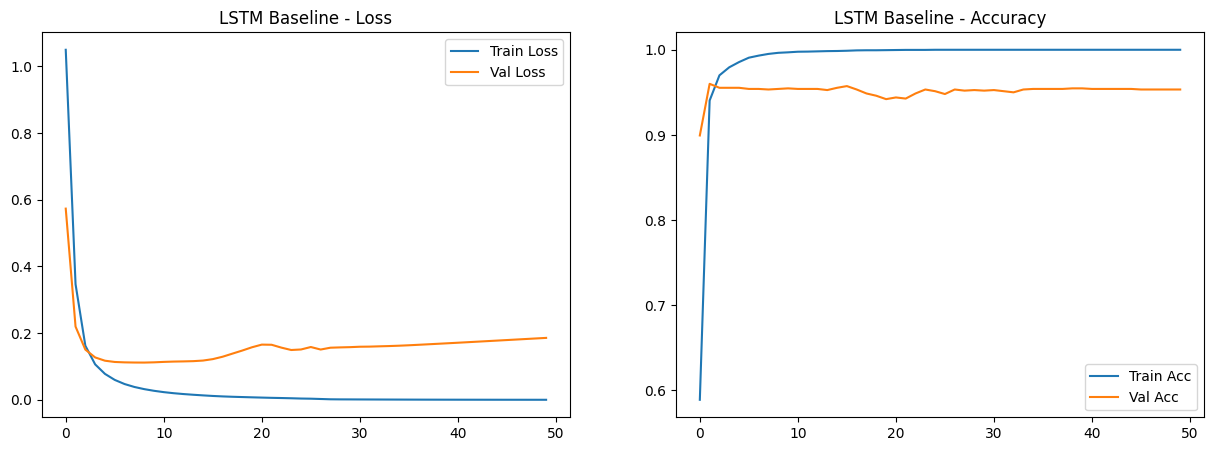

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9520 - loss: 0.2063
LSTM Baseline Test Acc: 0.9520


In [20]:
# Cell 8: LSTM Baseline (Overfitting) - Tương tự RNN nhưng dùng LSTM
def build_lstm_baseline(input_shape, n_classes=4):
    model = Sequential([
        LSTM(64, input_shape=input_shape, return_sequences=False),
        Dense(32, activation='relu'),
        Dense(n_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

lstm_baseline = build_lstm_baseline((1, n_features))
history_lstm_baseline = lstm_baseline.fit(X_train_rnn, y_train_cat,
                                          epochs=50,
                                          batch_size=64,
                                          validation_data=(X_val_rnn, y_val_cat),
                                          verbose=0)

# Plot baseline LSTM
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(history_lstm_baseline.history['loss'], label='Train Loss')
ax1.plot(history_lstm_baseline.history['val_loss'], label='Val Loss')
ax1.set_title('LSTM Baseline - Loss')
ax1.legend()

ax2.plot(history_lstm_baseline.history['accuracy'], label='Train Acc')
ax2.plot(history_lstm_baseline.history['val_accuracy'], label='Val Acc')
ax2.set_title('LSTM Baseline - Accuracy')
ax2.legend()
plt.show()

test_loss_lstm, test_acc_lstm = lstm_baseline.evaluate(X_test_rnn, y_test_cat)
print(f"LSTM Baseline Test Acc: {test_acc_lstm:.4f}")

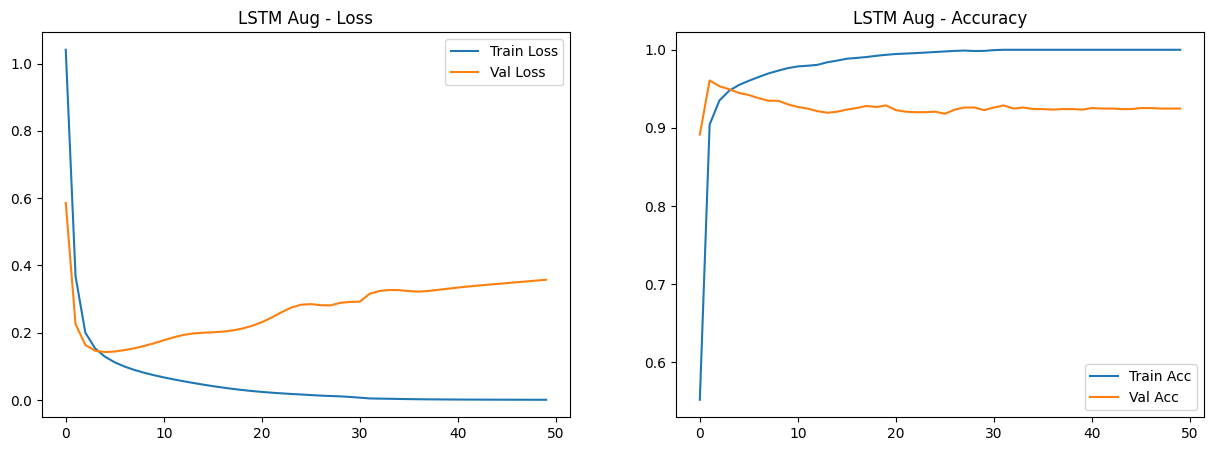

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9180 - loss: 0.3525
LSTM Aug Test Acc: 0.9180


In [21]:
# Cell 9: LSTM with Data Augmentation
lstm_aug = build_lstm_baseline((1, n_features))
history_lstm_aug = lstm_aug.fit(X_train_aug_rnn, y_train_cat,
                                epochs=50,
                                batch_size=64,
                                validation_data=(X_val_rnn, y_val_cat),
                                verbose=0)

# Plot aug LSTM
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(history_lstm_aug.history['loss'], label='Train Loss')
ax1.plot(history_lstm_aug.history['val_loss'], label='Val Loss')
ax1.set_title('LSTM Aug - Loss')
ax1.legend()

ax2.plot(history_lstm_aug.history['accuracy'], label='Train Acc')
ax2.plot(history_lstm_aug.history['val_accuracy'], label='Val Acc')
ax2.set_title('LSTM Aug - Accuracy')
ax2.legend()
plt.show()

test_loss_lstm_aug, test_acc_lstm_aug = lstm_aug.evaluate(X_test_rnn, y_test_cat)
print(f"LSTM Aug Test Acc: {test_acc_lstm_aug:.4f}")

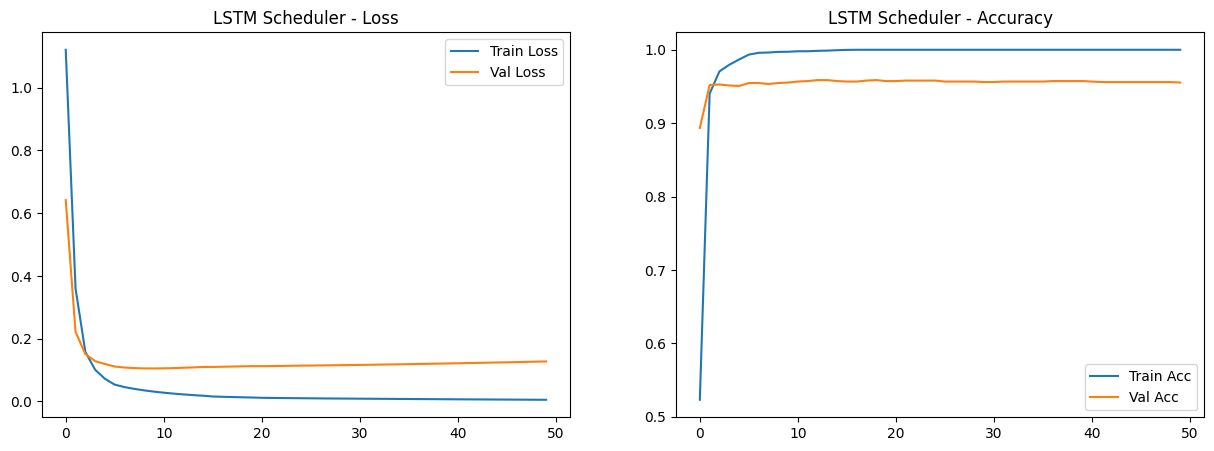

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9487 - loss: 0.1468
LSTM Scheduler Test Acc: 0.9487


In [22]:
# Cell 10: LSTM with LR Scheduler
lstm_scheduler = build_lstm_baseline((1, n_features))
history_lstm_scheduler = lstm_scheduler.fit(X_train_rnn, y_train_cat,
                                            epochs=50,
                                            batch_size=64,
                                            validation_data=(X_val_rnn, y_val_cat),
                                            callbacks=[lr_scheduler],
                                            verbose=0)

# Plot scheduler LSTM
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(history_lstm_scheduler.history['loss'], label='Train Loss')
ax1.plot(history_lstm_scheduler.history['val_loss'], label='Val Loss')
ax1.set_title('LSTM Scheduler - Loss')
ax1.legend()

ax2.plot(history_lstm_scheduler.history['accuracy'], label='Train Acc')
ax2.plot(history_lstm_scheduler.history['val_accuracy'], label='Val Acc')
ax2.set_title('LSTM Scheduler - Accuracy')
ax2.legend()
plt.show()

test_loss_lstm_sch, test_acc_lstm_sch = lstm_scheduler.evaluate(X_test_rnn, y_test_cat)
print(f"LSTM Scheduler Test Acc: {test_acc_lstm_sch:.4f}")

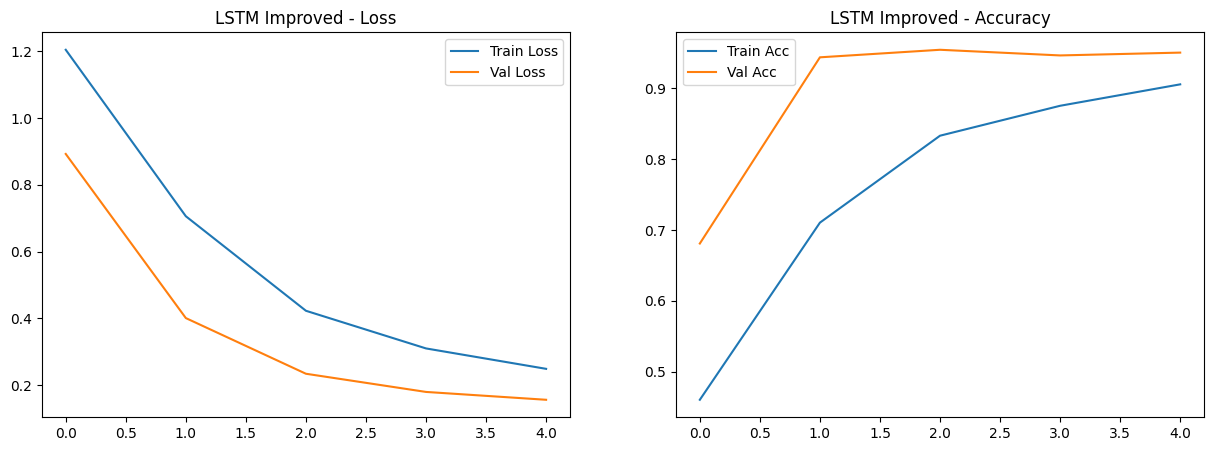

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6887 - loss: 0.8856
LSTM Improved Test Acc: 0.6887


In [23]:
# Cell 11: LSTM Improved (Dropout + EarlyStopping)
def build_lstm_improved(input_shape, n_classes=4):
    model = Sequential([
        LSTM(64, input_shape=input_shape, return_sequences=False),
        Dropout(0.4),
        Dense(32, activation='relu'),
        Dropout(0.4),
        Dense(n_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

lstm_improved = build_lstm_improved((1, n_features))
history_lstm_improved = lstm_improved.fit(X_train_rnn, y_train_cat,
                                          epochs=50,
                                          batch_size=64,
                                          validation_data=(X_val_rnn, y_val_cat),
                                          callbacks=[early_stop],
                                          verbose=0)

# Plot improved LSTM
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(history_lstm_improved.history['loss'], label='Train Loss')
ax1.plot(history_lstm_improved.history['val_loss'], label='Val Loss')
ax1.set_title('LSTM Improved - Loss')
ax1.legend()

ax2.plot(history_lstm_improved.history['accuracy'], label='Train Acc')
ax2.plot(history_lstm_improved.history['val_accuracy'], label='Val Acc')
ax2.set_title('LSTM Improved - Accuracy')
ax2.legend()
plt.show()

test_loss_lstm_imp, test_acc_lstm_imp = lstm_improved.evaluate(X_test_rnn, y_test_cat)
print(f"LSTM Improved Test Acc: {test_acc_lstm_imp:.4f}")

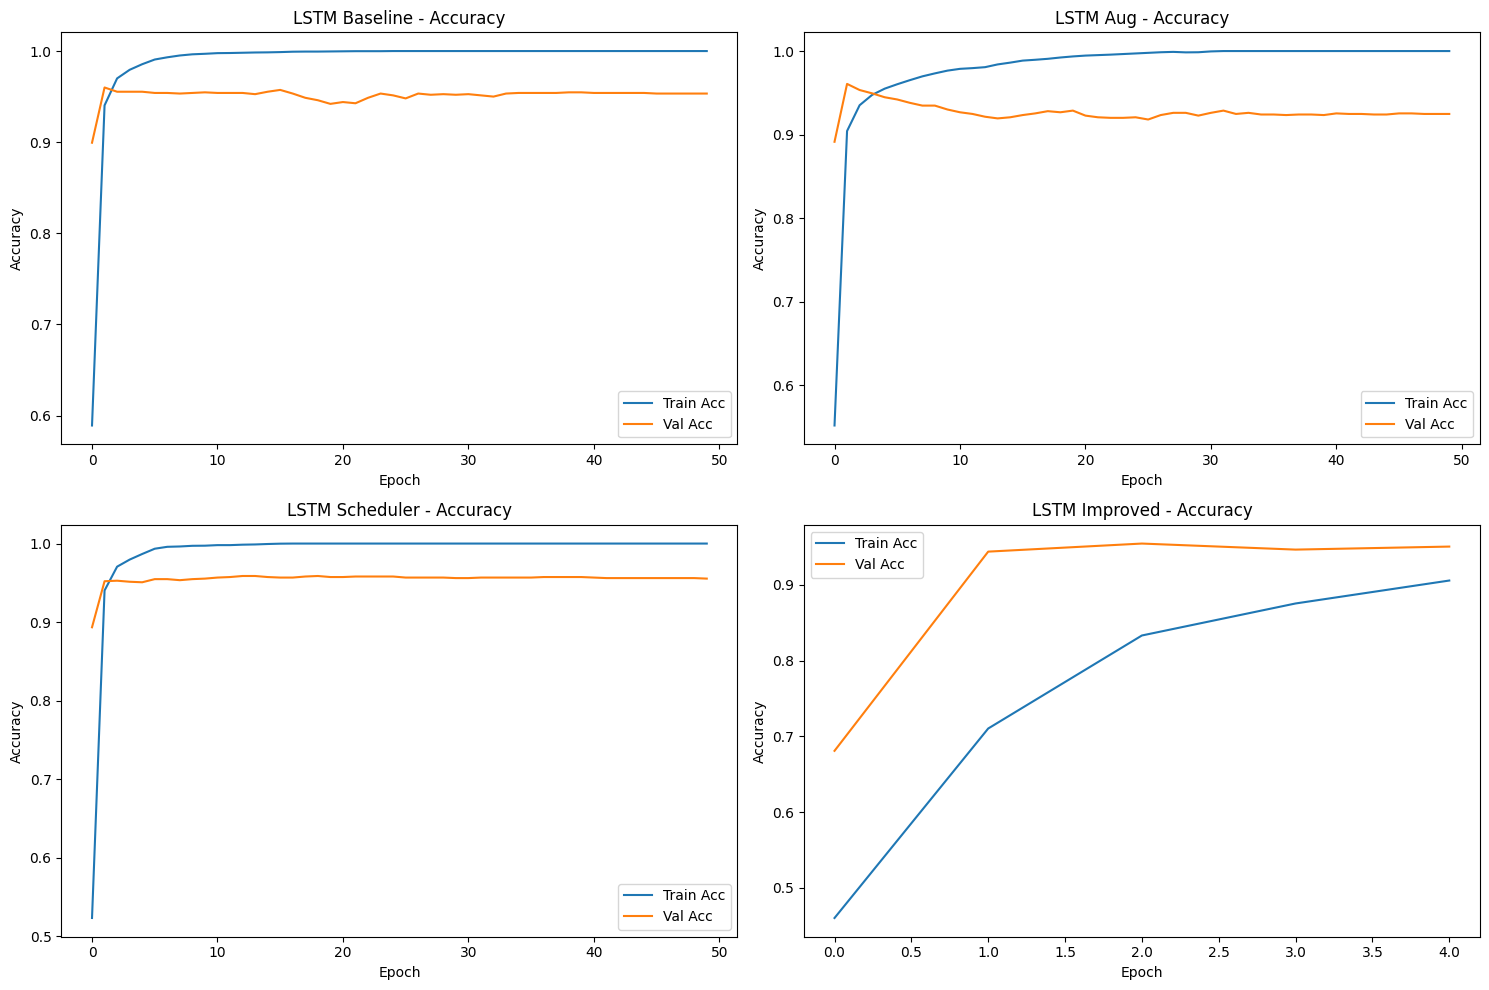

LSTM Comparison:
Method       Test Acc   Gap (Train-Val)
Baseline     0.9534     0.0466
Aug          0.9247     0.0753
Scheduler    0.9554     0.0446
Improved     0.9507     -0.0449


In [24]:
# Cell 12: So sánh LSTM methods (subplots)
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
methods = ['Baseline', 'Aug', 'Scheduler', 'Improved']
histories = [history_lstm_baseline, history_lstm_aug, history_lstm_scheduler, history_lstm_improved]

for i, (method, history) in enumerate(zip(methods, histories)):
    row, col = i // 2, i % 2
    axes[row, col].plot(history.history['accuracy'], label='Train Acc')
    axes[row, col].plot(history.history['val_accuracy'], label='Val Acc')
    axes[row, col].set_title(f'LSTM {method} - Accuracy')
    axes[row, col].legend()
    axes[row, col].set_xlabel('Epoch')
    axes[row, col].set_ylabel('Accuracy')

plt.tight_layout()
plt.show()

# Summary table for LSTM
print("LSTM Comparison:")
print(f"{'Method':<12} {'Test Acc':<10} {'Gap (Train-Val)':<15}")
for method, history in zip(methods, histories):
    final_train = history.history['accuracy'][-1]
    final_val = history.history['val_accuracy'][-1]
    gap = final_train - final_val
    print(f"{method:<12} {final_val:.4f}     {gap:.4f}")